# The Battle of Neighborhoods

## Clustering and Analysis of Safest Boroughs in London

### Table of Contents

- <font size="3">Introduction: Business Problem </font>
- <font size="3">Data </font>
- <font size="3">Methodology </font>
- <font size="3">Analysis </font>
- <font size="3">Results and Discussion </font>
- <font size="3">Conclusion </font>

### Introduction: Business Problem

The aim of this project is to find out the safest borough in London based on the __total crimes__, explore the __neighborhoods__ of that borough. Find the __10 most common venues__ in each neighborhood and finally cluster the neighborhoods using __k-means clustering__.

This report targets people who are looking forward to __relocate to London__. While moving to a new place and for finalising a neighborhood to hunt for an apartment, __safety__ is considered to be the top concern. You need to feel safe in your own home in order to be able to enjoy living there. __The crime statistics__ will provide an insight into this issue.

We will focus on the safest borough and explore its neighborhoods. We will find out the 10 most common venues in each neighborhood so that the neighborhood best suited to an individual's needs can be selected.

### Data

We will need following data sources to generate required information:
- <font size="3">__Part 1__: [Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016](https://www.kaggle.com/jboysen/london-crime): A dataset consisting of the crime statistics of each borough in London obtained from Kaggle </font>
- <font size="3">__Part 2__: [Scraping additional information of the different Boroughs in London from a Wikipedia page.](https://en.wikipedia.org/wiki/List_of_London_boroughs): More information regarding the boroughs of London is scraped using the Beautifulsoup library </font>
- <font size="3">__Part 3__: Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.: Co-ordinates of neighborhood will be obtained using __Google Maps API geocoding__ </font>

Factors that will influence our decision:
- <font size = "3">The total number of crimes commited in each of the borough during the last year. </font>
- <font size = "3">The most common venues in each of the neighborhood in the safest borough selected. </font>

#### Part 1: Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016:

#### London Crime Data

The dataset consists of folowing columns:
- <font size="3">lsoa_code: code for Lower Super Output Area in Greater London.</font>
- <font size="3">borough: Common name for London borough.</font>
- <font size="3">major_category: High level categorization of crime </font>
- <font size="3">minor_category: Low level categorization of crime within major category. </font>
- <font size="3">value: monthly reported count of categorical crime in given borough</font>
- <font size="3">year: Year of reported counts, 2008-2016 </font>
- <font size="3">month: Month of reported counts, 1-12 </font>

Data set URL: https://www.kaggle.com/jboysen/london-crime

#### Import required libraries

In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geocoder --yes
import geocoder

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

!pip install beautifulsoup4
from bs4 import BeautifulSoup # library for web scrapping  

print('Folium installed')
print('Libraries imported.')

#### Define Foursquare Credentials and Version
For this step, you must have a Foursquare developer account created and have your credentials handy

In [4]:
CLIENT_ID = 'LLAXJB3OV14G12V34FQF2LC4QKHZ5MWWWUIELSKV1V3KXVPB' # your Foursquare ID
CLIENT_SECRET = 'B4PXE1B2S4QZKVBCSXOH1S2FHISKGPJG0X2XG2LRBARV1QWB' # your Foursquare Secret

VERSION = '20180604' 
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LLAXJB3OV14G12V34FQF2LC4QKHZ5MWWWUIELSKV1V3KXVPB
CLIENT_SECRET:B4PXE1B2S4QZKVBCSXOH1S2FHISKGPJG0X2XG2LRBARV1QWB


#### Read the dataset into a dataframe

In [87]:
df = pd.read_csv("london_crime_by_lsoa.csv")
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0.0,2016.0,11.0
1,E01001646,Greenwich,Violence Against the Person,Other violence,0.0,2016.0,11.0
2,E01000677,Bromley,Violence Against the Person,Other violence,0.0,2015.0,5.0
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0.0,2016.0,3.0
4,E01004563,Wandsworth,Robbery,Personal Property,0.0,2008.0,6.0


#### Accessing the most recent crime rates (2016)

In [88]:
# Taking only the most recent year (2016) and dropping the rest
df.drop(df.index[df['year'] != 2016], inplace = True)

# Removing all the entires where crime values are null  
df = df[df.value != 0]

# Reset the index and dropping the previous index
df = df.reset_index(drop=True)

In [89]:
# Shape of the data frame
df.shape

(238751, 7)

In [10]:
# View the top of the dataset 
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1.0,2016.0,8.0
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1.0,2016.0,4.0
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4.0,2016.0,8.0
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1.0,2016.0,8.0
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2.0,2016.0,11.0


#### Change the column names

In [90]:
df.columns = ['LSOA_Code', 'Borough','Major_Category','Minor_Category','No_of_Crimes','Year','Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1.0,2016.0,8.0
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1.0,2016.0,4.0
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4.0,2016.0,8.0
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1.0,2016.0,8.0
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2.0,2016.0,11.0


In [12]:
# View dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238751 entries, 0 to 238750
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LSOA_Code       238751 non-null  object 
 1   Borough         238751 non-null  object 
 2   Major_Category  238751 non-null  object 
 3   Minor_Category  238751 non-null  object 
 4   No_of_Crimes    238751 non-null  float64
 5   Year            238751 non-null  float64
 6   Month           238751 non-null  float64
dtypes: float64(3), object(4)
memory usage: 12.8+ MB


#### Total number of crimes in each borough

In [20]:
df['Borough'].value_counts()

Lambeth                   10726
Southwark                 10044
Croydon                    9806
Newham                     9534
Tower Hamlets              9307
Ealing                     9240
Brent                      9109
Barnet                     8956
Hackney                    8729
Lewisham                   8704
Haringey                   8601
Enfield                    8272
Wandsworth                 8198
Westminster                8082
Islington                  8042
Camden                     7747
Greenwich                  7747
Hounslow                   7601
Hillingdon                 7498
Waltham Forest             7443
Bromley                    7258
Redbridge                  7004
Hammersmith and Fulham     6256
Barking and Dagenham       5997
Havering                   5896
Kensington and Chelsea     5889
Harrow                     5069
Merton                     5048
Bexley                     5036
Richmond upon Thames       4376
Sutton                     4175
Kingston

#### Total crimes per major category

In [21]:
df['Major_Category'].value_counts()

Theft and Handling             78459
Violence Against the Person    74921
Criminal Damage                29830
Burglary                       26199
Drugs                          13297
Robbery                         9021
Other Notifiable Offences       7024
Name: Major_Category, dtype: int64

#### Pivoting the table to view number of crimes for each major category in each borough

In [91]:
import numpy as np
London_crime_data = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Borough'],
                               columns=['Major_Category'],
                               aggfunc=np.sum,fill_value=0)
London_crime_data.head()

No_of_Crimes                        \
Major_Category           Burglary Criminal Damage Drugs   
Borough                                                   
Barking and Dagenham          823            1203   549   
Barnet                       2082            1355   564   
Bexley                        662            1057   412   
Brent                        1571            1411  1247   
Bromley                      1392            1359   440   

                                                                           \
Major_Category       Other Notifiable Offences Robbery Theft and Handling   
Borough                                                                     
Barking and Dagenham                       234     311               3528   
Barnet                                     291     278               5789   
Bexley                                     176     111               2803   
Brent                                      305     513               5620   
Bromley                                    260     227               4530   

                                                  
Major_Category       Violence Against the Person  
Borough                                           
Barking and Dagenham                        3735  
Barnet                                      4600  
Bexley                                      2676  
Brent                                       5563  
Bromley                                     3908

In [92]:
# Reset the index
London_crime_data.reset_index(inplace = True)

In [93]:
# Total crimes per Borough
London_crime_data['Total'] = London_crime_data.sum(axis=1)
London_crime_data.head(33)

Borough No_of_Crimes                        \
Major_Category                             Burglary Criminal Damage Drugs   
0                 Barking and Dagenham          823            1203   549   
1                               Barnet         2082            1355   564   
2                               Bexley          662            1057   412   
3                                Brent         1571            1411  1247   
4                              Bromley         1392            1359   440   
5                               Camden         1594            1192   903   
6                       City of London            1               1     6   
7                              Croydon         1671            1926   788   
8                               Ealing         1480            1554   814   
9                              Enfield         1537            1253   643   
10                           Greenwich         1091            1499   531   
11                             Hackney         1649            1238   827   
12              Hammersmith and Fulham          904             909   789   
13                            Haringey         1470            1331   862   
14                              Harrow         1250             742   307   
15                            Havering         1107            1113   475   
16                          Hillingdon         1362            1506   650   
17                            Hounslow         1098            1407   707   
18                           Islington         1250            1205  1098   
19              Kensington and Chelsea          834             644  1127   
20                Kingston upon Thames          532             633   435   
21                             Lambeth         1909            1709  1741   
22                            Lewisham         1255            1448   984   
23                              Merton          873             874   282   
24                              Newham         1327            1585  1004   
25                           Redbridge         1187             990   597   
26                Richmond upon Thames          768             739   178   
27                           Southwark         1760            1581  1151   
28                              Sutton          775             786   268   
29                       Tower Hamlets         1732            1485  1015   
30                      Waltham Forest         1095            1236   667   
31                          Wandsworth         1472            1123   487   
32                         Westminster         1952            1345  1184   

                                                                     \
Major_Category Other Notifiable Offences Robbery Theft and Handling   
0                                    234     311               3528   
1                                    291     278               5789   
2                                    176     111               2803   
3                                    305     513               5620   
4                                    260     227               4530   
5                                    277     538               8569   
6                                      1       3                 70   
7                                    457     672               5530   
8                                    394     412               6254   
9                                    301     479               4942   
10                                   312     310               4913   
11                                   309     617               7056   
12                                   282     249               5502   
13                                   331     731               6550   
14                                   171     230               2734   
15                                   234     179               3629   
16                                   619     240         

#### Remove multi index for easier merging

In [94]:
London_crime_data.columns = London_crime_data.columns.map(''.join)
London_crime_data.head()

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,Barking and Dagenham,823,1203,549,234,311,3528,3735,10383
1,Barnet,2082,1355,564,291,278,5789,4600,14959
2,Bexley,662,1057,412,176,111,2803,2676,7897
3,Brent,1571,1411,1247,305,513,5620,5563,16230
4,Bromley,1392,1359,440,260,227,4530,3908,12116


#### Renaming columns

In [95]:
London_crime_data.columns = ['Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
London_crime_data.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,823,1203,549,234,311,3528,3735,10383
1,Barnet,2082,1355,564,291,278,5789,4600,14959
2,Bexley,662,1057,412,176,111,2803,2676,7897
3,Brent,1571,1411,1247,305,513,5620,5563,16230
4,Bromley,1392,1359,440,260,227,4530,3908,12116


In [18]:
London_crime_data.shape

(33, 9)

#### Part 2: Scraping additional information of different boroughs in London from wikipedia page

#### Using beautiful soup the latitude and longitude of boroughs in London
URL: https://en.wikipedia.org/wiki/List_of_London_boroughs

In [ ]:
# scraping data from wikipedia
wikipedia_link='https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
print(soup.prettify())

In [ ]:
# extracting the raw table inside that webpage
table = soup.find_all('table', {'class':'wikitable sortable'})
print(table)

#### Convert the table into a dataframe

In [98]:
import pandas as pd
London_Boroughs_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
London_Boroughs_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


#### Another table on the same wikipedia page contains the Borough City of London

In [99]:
# Read City of London in a second table 
London_CL_table = pd.read_html(str(table[1]), index_col=None, header=0)[0]

# Rename the columns to match the previous table to append the tables.

London_CL_table.columns = ['Borough','Inner','Status','Local authority','Political control',
                         'Headquarters','Area (sq mi)','Population (2013 est)[1]','Co-ordinates','Nr. in map']

# View the table
London_CL_table

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


#### Append to London_Boroughs_table dataframe

In [100]:
# A continuous index value will be maintained 
# across the rows in the new appended data frame. 

London_Boroughs_table = London_Boroughs_table.append(London_CL_table, ignore_index = True) 
London_Boroughs_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [101]:
# Check if the last row was correctly appended
London_Boroughs_table.tail(2)

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


In [102]:
London_Boroughs_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Borough                   33 non-null     object 
 1   Inner                     4 non-null      object 
 2   Status                    5 non-null      object 
 3   Local authority           33 non-null     object 
 4   Political control         33 non-null     object 
 5   Headquarters              33 non-null     object 
 6   Area (sq mi)              33 non-null     float64
 7   Population (2013 est)[1]  33 non-null     int64  
 8   Co-ordinates              33 non-null     object 
 9   Nr. in map                33 non-null     int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.7+ KB


#### Remove unnecessary string from dataset

In [103]:
London_Boroughs_table = London_Boroughs_table.replace('note 1','', regex=True) 
London_Boroughs_table = London_Boroughs_table.replace('note 2','', regex=True) 
London_Boroughs_table = London_Boroughs_table.replace('note 3','', regex=True) 
London_Boroughs_table = London_Boroughs_table.replace('note 4','', regex=True) 
London_Boroughs_table = London_Boroughs_table.replace('note 5','', regex=True) 

London_Boroughs_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [12]:
# Shape of the data frame
London_Boroughs_table.shape

(33, 10)

#### Check if the borough in both dataframes match

In [104]:
set(df.Borough) - set(London_Boroughs_table.Borough)

{'Barking and Dagenham', 'Greenwich', 'Hammersmith and Fulham'}

The above three boroughs do not match because of the unnecessary symbols

#### Let us find the index of the boroughs that did not match

In [105]:
print("The index of first borough is",London_Boroughs_table.index[London_Boroughs_table['Borough'] == 'Barking and Dagenham []'].tolist())
print("The index of second borough is",London_Boroughs_table.index[London_Boroughs_table['Borough'] == 'Greenwich []'].tolist())
print("The index of third borough is",London_Boroughs_table.index[London_Boroughs_table['Borough'] == 'Hammersmith and Fulham []'].tolist())

The index of first borough is [0]
The index of second borough is [9]
The index of third borough is [11]


#### We need to change the borough names to match the other dataframe

In [106]:
London_Boroughs_table.iloc[0,0] = 'Barking and Dagenham'
London_Boroughs_table.iloc[9,0] = 'Greenwich'
London_Boroughs_table.iloc[11,0] = 'Hammersmith and Fulham'

In [107]:
# Check if they match now
set(df.Borough) - set(London_Boroughs_table.Borough)

set()

#### Now combine both the dataframes

In [108]:
Lndn_crime = pd.merge(London_crime_data, London_Boroughs_table, on='Borough')
Lndn_crime.head(10)

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham,823,1203,549,234,311,3528,3735,10383,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,2082,1355,564,291,278,5789,4600,14959,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,662,1057,412,176,111,2803,2676,7897,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,1571,1411,1247,305,513,5620,5563,16230,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,1392,1359,440,260,227,4530,3908,12116,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,1594,1192,903,277,538,8569,4752,17825,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,City of London,1,1,6,1,3,70,15,97,([],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1
7,Croydon,1671,1926,788,457,672,5530,6138,17182,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
8,Ealing,1480,1554,814,394,412,6254,5641,16549,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
9,Enfield,1537,1253,643,301,479,4942,4560,13715,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30


In [109]:
Lndn_crime.shape

(33, 18)

In [110]:
set(df.Borough) - set(Lndn_crime.Borough)

set()

#### Let us rearrange the columns

In [111]:
list(Lndn_crime)

['Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Other Notifiable Offences',
 'Robbery',
 'Theft and Handling',
 'Violence Against the Person',
 'Total',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2013 est)[1]',
 'Co-ordinates',
 'Nr. in map']

In [112]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Lndn_crime = Lndn_crime.reindex(columns=columnsTitles)

Lndn_crime = Lndn_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Lndn_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,823,1203,549,234,311,3528,3735,10383
1,Barnet,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,2082,1355,564,291,278,5789,4600,14959
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,662,1057,412,176,111,2803,2676,7897
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,1571,1411,1247,305,513,5620,5563,16230
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,1392,1359,440,260,227,4530,3908,12116


### Methodology

The methodology is divided into two parts for this project:
- <font size="3">__Exploratory Data Analysis__: Identify the safest borough in London by visualizing the crime rates. Find the 10 most common venues by extracting the neighborhoods in that borough</font>
- <font size="3">__Modelling__: We will use k-means clustering to cluster similar neighborhoods, which will help people find similar neighborhoods in the safest borough. Since k-means clustering uses predefined cluster size, we will use a cluster size=5, and cluster 15 neighborhoods into 5 clusters. K-means will help us to cluster similar venues together, which in turn will help people to shortlist the area of their interest based on venues/amenities near each neighborhood.</font>

#### Exploratory Data Analysis

Descriptive Statistics

In [113]:
London_crime_data.describe()

,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,1256.515152,1195.121212,719.151515,285.151515,411.696970,5429.636364,4272.969697,13570.242424
std,451.837991,380.840334,362.618526,117.046497,264.500294,2850.484858,1515.739743,5377.517945
min,1.000000,1.000000,6.000000,1.000000,3.000000,70.000000,15.000000,97.000000
25%,904.000000,990.000000,475.000000,222.000000,230.000000,3629.000000,3661.000000,10398.000000
50%,1255.000000,1238.000000,667.000000,291.000000,362.000000,5423.000000,4578.000000,13854.000000
75%,1571.000000,1448.000000,984.000000,331.000000,558.000000,6662.000000,5340.000000,16601.000000
max,2082.000000,1926.000000,1741.000000,619.000000,1090.000000,17073.000000,6417.000000,29500.000000


In [114]:
# check for matplotlib version
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Matplotlib version:  3.1.1


Check if the column names are strings

In [115]:
Lndn_crime.columns = list(map(str, Lndn_crime.columns))
# let's check the column labels types now
all(isinstance(column, str) for column in Lndn_crime.columns)

True

Sort the Total crimes column in ascending order to view 5 boroughs with least number of crimes

In [116]:
Lndn_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Lndn_crime.head() 
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1,1,6,1,3,70,15,97
20,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,532,633,435,130,68,1996,1964,5758
28,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,775,786,268,149,103,2208,2220,6509
26,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,768,739,178,138,66,2964,1917,6770
23,Merton,Merton London Borough Council,Labour,"Civic Centre, London Road",14.52,203223,51°24′05″N 0°11′45″W﻿ / ﻿51.4014°N 0.1958°W,873,874,282,166,190,3003,2423,7811


Visualize these 5 boroughs

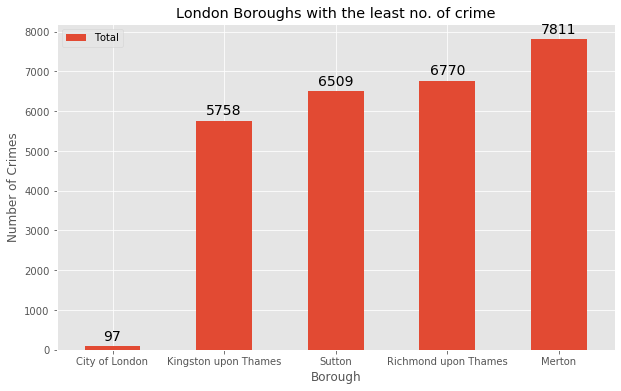

In [117]:
df_bt = df_bot5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

It is evident that the borough __City of London__ has recorded least number of crimes for the year 2016. We shall further explore this borough

In [118]:
df_col = df_bot5[df_bot5['Borough'] == 'City of London']
df_col = df_col[['Borough','Total','Area (sq mi)','Population (2013 est)[1]']]
df_col

,Borough,Total,Area (sq mi),Population (2013 est)[1]
6,City of London,97,1.12,7000


As per the below wikipedia page, City of London is the 33rd principal division of Greater London and is not a London borough. Due to above reason it has less number of crimes recorded. Therefore, we shall focus on the next borough with least crimes i.e., '__Kingston upon Thames__'
Url: https://en.wikipedia.org/wiki/List_of_London_boroughs

Visualizing the different crimes in the borough of __Kingston upon Thames__

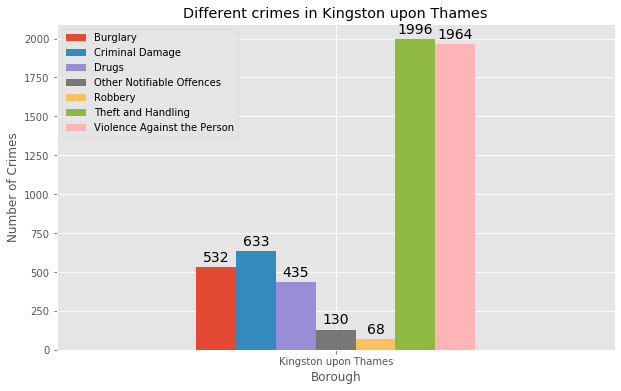

In [119]:
df_bc1 =  df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('Different crimes in Kingston upon Thames') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

We can conclude that the borough __Kingston upon Thames__ is safest among all boroughs in London

#### Part 3: Creating a new dataset of the neighborhoods of the safest borough in London and generating their co-ordinates

The list of neighborhoods in the Royal borough of Kingston upon Thames is available on below wikipedia page;
https://en.wikipedia.org/wiki/List_of_districts_in_the_Royal_Borough_of_Kingston_upon_Thames

In [120]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


Find the latitude and longitude of all the neighborhoods in Kingston upon Thames

In [121]:
from geopy.geocoders import Nominatim 
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.30555280504926163, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


In [122]:
df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


Get the co-ordinates of Berrylands neighborhood (A central neighborhood in Kingston upon Thames)

In [123]:
address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berrylands, London are 51.3937811, -0.2848024.


Visualize the neighborhood in Kingston upon Thames borough

In [124]:
# create map of London using latitude and longitude values
import folium # plotting library
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

#### Modelling

- <Font size='3'>Finding all the venues within 500m radius of each neighborhood.</Font>
- <Font size='3'>Perform one hot encoding on the venues data.</Font>
- <Font size='3'>Grouping the venues by the neighborhood and calculating their mean.</Font>
- <Font size='3'>Performing a K-means clustering (Defining K = 5)</Font>

We will create a function to extract venues for each neighborhood

In [125]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [126]:
kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )

Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [150]:
print(kut_venues.shape)
kut_venues.head()

(169, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,Alexandra Park,51.394230,-0.281206,Park
2,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
3,Canbury,51.417499,-0.305553,Canbury Gardens,51.417409,-0.305300,Park
4,Canbury,51.417499,-0.305553,The Boater's Inn,51.418546,-0.305915,Pub


In [128]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,3,3,3,3,3,3
Canbury,15,15,15,15,15,15
Hook,4,4,4,4,4,4
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,4,4,4,4,4,4
Motspur Park,5,5,5,5,5,5
New Malden,7,7,7,7,7,7
Norbiton,26,26,26,26,26,26


In [129]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 72 uniques categories.


##### One hot encoding

In [130]:
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and take the mean of the frequency of occurence of every category

In [131]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Canbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.066667,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Hook,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Kingston Vale,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Kingston upon Thames,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.066667,0.000000,0.033333,0.033333,0.000000,0.000000
5,Malden Rushett,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Motspur Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,New Malden,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000
8,Norbiton,0.000000,0.038462,0.038462,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.038462,0.038462,0.000000,0.000000,0.038462,0.000000,0.000000,0.038462
9,Old Malden,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000


In [153]:
kut_grouped.shape

(13, 73)

In [154]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                   venue  freq
0   Gym / Fitness Center  0.33
1               Bus Stop  0.33
2                   Park  0.33
3  Portuguese Restaurant  0.00
4             Playground  0.00


----Canbury----
               venue  freq
0                Pub  0.27
1     Shop & Service  0.07
2              Hotel  0.07
3  Indian Restaurant  0.07
4               Park  0.07


----Hook----
               venue  freq
0  Indian Restaurant  0.25
1             Bakery  0.25
2  Fish & Chips Shop  0.25
3        Supermarket  0.25
4   Asian Restaurant  0.00


----Kingston Vale----
            venue  freq
0    Soccer Field  0.25
1   Grocery Store  0.25
2             Bar  0.25
3  Sandwich Place  0.25
4          Market  0.00


----Kingston upon Thames----
              venue  freq
0              Café  0.10
1  Sushi Restaurant  0.07
2               Pub  0.07
3      Burger Joint  0.07
4       Coffee Shop  0.07


----Malden Rushett----
              venue  freq
0               Pub  0.25
1     

##### Create a venues dataframe

create a function to sort venues in descending order

In [155]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new dataframe and display the top 10 venues for each neighborhood

In [156]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Food,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
1,Canbury,Pub,River,Café,Supermarket,Spa,Gym / Fitness Center,Shop & Service,Fish & Chips Shop,Plaza,Park
2,Hook,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Wine Shop,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant
3,Kingston Vale,Sandwich Place,Grocery Store,Bar,Soccer Field,Wine Shop,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
4,Kingston upon Thames,Café,Pub,Sushi Restaurant,Coffee Shop,Burger Joint,Asian Restaurant,German Restaurant,Gift Shop,French Restaurant,Electronics Store


#### Clustering similar neighborhoods using k-means clustering

In [157]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 3, 4, 1, 3, 1, 2, 3, 3, 0], dtype=int32)

In [158]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,2.0,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Food,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
1,Canbury,Kingston upon Thames,51.417499,-0.305553,3.0,Pub,River,Café,Supermarket,Spa,Gym / Fitness Center,Shop & Service,Fish & Chips Shop,Plaza,Park
2,Chessington,Kingston upon Thames,51.358336,-0.298622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Coombe,Kingston upon Thames,51.419450,-0.265398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hook,Kingston upon Thames,51.367898,-0.307145,4.0,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Wine Shop,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant


In [67]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            15 non-null     object 
 1   Borough                 15 non-null     object 
 2   Latitude                15 non-null     float64
 3   Longitude               15 non-null     float64
 4   Cluster Labels          13 non-null     float64
 5   1st Most Common Venue   13 non-null     object 
 6   2nd Most Common Venue   13 non-null     object 
 7   3rd Most Common Venue   13 non-null     object 
 8   4th Most Common Venue   13 non-null     object 
 9   5th Most Common Venue   13 non-null     object 
 10  6th Most Common Venue   13 non-null     object 
 11  7th Most Common Venue   13 non-null     object 
 12  8th Most Common Venue   13 non-null     object 
 13  9th Most Common Venue   13 non-null     object 
 14  10th Most Common Venue  13 non-null     obje

In [159]:
# Dropping the row with the NaN value 
kut_merged.dropna(inplace = True)

In [160]:
kut_merged.shape

(13, 15)

In [161]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [162]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            13 non-null     object 
 1   Borough                 13 non-null     object 
 2   Latitude                13 non-null     float64
 3   Longitude               13 non-null     float64
 4   Cluster Labels          13 non-null     int64  
 5   1st Most Common Venue   13 non-null     object 
 6   2nd Most Common Venue   13 non-null     object 
 7   3rd Most Common Venue   13 non-null     object 
 8   4th Most Common Venue   13 non-null     object 
 9   5th Most Common Venue   13 non-null     object 
 10  6th Most Common Venue   13 non-null     object 
 11  7th Most Common Venue   13 non-null     object 
 12  8th Most Common Venue   13 non-null     object 
 13  9th Most Common Venue   13 non-null     object 
 14  10th Most Common Venue  13 non-null     obje

#### Visualize the clusters

In [163]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

As we can see above, every cluster is color coded for the ease of presentation. A majority of the neighborhood falls in the green cluster which is the 4th cluster. Two neighborhoods have their own cluster (Red and Yellow), these are clusters two 1 and 5. The 2nd cluster is the purple cluster consisting of three neighborhoods. Blue cluster consisting of two neighborhoods is the 3rd cluster.

### Analysis

Here we will analyse each of the clusters to identify their characteristics and their neighborhoods

##### First Cluster

In [164]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Old Malden,Kingston upon Thames,51.382484,-0.25909,0,Construction & Landscaping,Pub,Food,Train Station,Bagel Shop,Department Store,Golf Course,Gift Shop,German Restaurant,Gastropub


The first cluster has one neighborhood with venues such as train station, restaurant and grocery store.

##### Second Cluster

In [165]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138,1,Sandwich Place,Grocery Store,Bar,Soccer Field,Wine Shop,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,1,Grocery Store,Pub,Garden Center,Restaurant,Wine Shop,Fast Food Restaurant,Department Store,Discount Store,Electronics Store,Farmers Market
14,Tolworth,Kingston upon Thames,51.378876,-0.282860,1,Grocery Store,Pharmacy,Restaurant,Discount Store,Hotel,Bus Stop,Italian Restaurant,Sandwich Place,Bowling Alley,Soccer Field


The second cluster has three neighborhoods consisting of venues such as wine shops, bars, restaurants, electronics stores, Bus stop, pharmacy, soccer field, farmers market and grocery stores.

##### Third Cluster

In [166]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,2,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Food,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898,2,Gym,Park,Bus Stop,Restaurant,Soccer Field,Fast Food Restaurant,Department Store,Discount Store,Electronics Store,Farmers Market


The third cluster has two neighborhoods with common venues as Gym, park, bus stop, restaurants, electronic stores and soccer field.

##### Fourth CLuster

In [167]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.417499,-0.305553,3,Pub,River,Café,Supermarket,Spa,Gym / Fitness Center,Shop & Service,Fish & Chips Shop,Plaza,Park
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,3,Café,Pub,Sushi Restaurant,Coffee Shop,Burger Joint,Asian Restaurant,German Restaurant,Gift Shop,French Restaurant,Electronics Store
9,New Malden,Kingston upon Thames,51.405335,-0.263407,3,Gym,Sushi Restaurant,Korean Restaurant,Bar,Supermarket,Indian Restaurant,Gastropub,Garden Center,Furniture / Home Store,Fried Chicken Joint
10,Norbiton,Kingston upon Thames,51.409999,-0.287396,3,Food,Indian Restaurant,Italian Restaurant,Pub,Wine Shop,Rental Car Location,Hardware Store,Hotel,Japanese Restaurant,Coffee Shop
12,Seething Wells,Kingston upon Thames,51.392642,-0.314366,3,Indian Restaurant,Coffee Shop,Pub,Gym,Pet Café,Playground,Chinese Restaurant,Café,Restaurant,Fast Food Restaurant
13,Surbiton,Kingston upon Thames,51.393756,-0.303310,3,Coffee Shop,Pub,Pharmacy,Italian Restaurant,Grocery Store,Gym / Fitness Center,Deli / Bodega,Farmers Market,Gastropub,Hotel


The fourth cluster is the biggest of all with 6 of the 15 neighborhoods in the Kingston upon Thames borough. We can see that the most common venues in these neighborhoods are Restaurants, Pubs, Cafe, Supermarkets, and stores.

##### Fifth Cluster

In [146]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Hook,Kingston upon Thames,51.367898,-0.307145,4,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Wine Shop,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant


The fifth cluster has one neighborhood which has venues such as wine shop, supermarket, Restaurants and electronics store.

### Results and Discussion

This project helps people wanting to relocate to safest borough in London. Expats can select a neigborhood of their choice based on its most common venues. So, if someone wants to live in a neighborhood with good connectivity and ease of transportation, they can  choose from cluster 1, cluster 2 and cluster 3, which have train station and bus stop as common venues. If the need is to live in a neighborhood with stores and restaurants in close proximity, then the neighborhoods in cluster 2 and 4 are suitable. Cluster 3 is most suitable for families because of the presence of Parks, Gym/Fitness centers, bus stops, restaurants, electronics stores and soccer field.

### Conclusion

In this project we have taken safety as a primary concern to choose from a number of boroughs in London. Also, it helps people get a better understanding of the neighborhoods in London with respect to the most common venues in those neighborhoods. Using technology to find out more about places before moving into a neighborhood, helps us to stay a step ahead. This project can further be extended to finding out other factors such as cost of living in selected areas, in order to move to a place that is safe and also well within budget.